# Monte Carlo feature sampling
Our model's cross-validation method for predicting yield is based on observations that can be aggregated by \{geography\} and \{time\}. To bolster validity for predictions in out-of-sample years, we will generate predictions for each future period by constructing yield *distributions* from simulations. These simulations will be conducted on input features sampled with Monte Carlo methods.

This notebook will proceed through the above process as follows:
1. Evaluate distributions of all input features
2. Investigate correlation among features
3. Implement Monte Carlo sampling for all relevant features.

This output will be used as input for our top-performing ML models:
4. Predict future yield.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os


## Some preliminary EDA on Kaggle dataset
Link [here](https://www.kaggle.com/datasets/kevinzmith/honey-with-neonic-pesticide)

In [2]:
kag = pd.read_csv('../04 - Data/Raw_Data/vHoneyNeonic_v02.csv')

In [3]:
kag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   state          825 non-null    object 
 1   numcol         825 non-null    float64
 2   yieldpercol    825 non-null    int64  
 3   totalprod      825 non-null    float64
 4   stocks         825 non-null    float64
 5   priceperlb     825 non-null    float64
 6   prodvalue      825 non-null    float64
 7   year           825 non-null    int64  
 8   StateName      825 non-null    object 
 9   Region         825 non-null    object 
 10  nCLOTHIANIDIN  761 non-null    float64
 11  nIMIDACLOPRID  761 non-null    float64
 12  nTHIAMETHOXAM  761 non-null    float64
 13  nACETAMIPRID   761 non-null    float64
 14  nTHIACLOPRID   761 non-null    float64
 15  nAllNeonic     761 non-null    float64
dtypes: float64(11), int64(2), object(3)
memory usage: 103.2+ KB


In [4]:
kag.head()

,state,numcol,yieldpercol,totalprod,stocks,priceperlb,prodvalue,year,StateName,Region,nCLOTHIANIDIN,nIMIDACLOPRID,nTHIAMETHOXAM,nACETAMIPRID,nTHIACLOPRID,nAllNeonic
0,AL,11000.0,56,616000.0,209000.0,1.49,918000.0,2007,Alabama,South,7696.2,3258.1,4149.6,0.0,0.0,15103.9
1,AL,11000.0,72,792000.0,230000.0,1.21,958000.0,2006,Alabama,South,680.0,4230.2,5371.6,0.0,0.0,10281.8
2,AL,12000.0,86,1032000.0,103000.0,1.18,1218000.0,2002,Alabama,South,0.0,1178.8,840.4,0.0,0.0,2019.2
3,AL,12000.0,87,1044000.0,282000.0,1.41,1472000.0,2004,Alabama,South,2676.4,1323.9,3863.9,0.0,0.0,7864.2
4,AL,13000.0,66,858000.0,266000.0,1.02,875000.0,2005,Alabama,South,1503.6,994.5,5493.9,0.0,0.0,7992.0


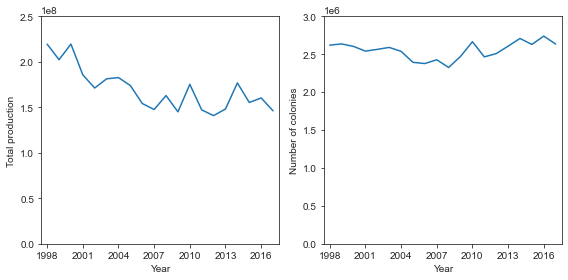

In [5]:
# Preparing data for line plot
years = kag.year.sort_values().unique()
totalprod = kag[['year','totalprod']].groupby(
  'year', as_index=False
).sum().sort_values('year').totalprod.values
numcol = kag[['year','numcol']].groupby(
  'year', as_index=False
).sum().sort_values('year').numcol.values

# Set figure style & size
sns.set_style('ticks')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

# Production plot
ax1.plot(
  years,
  totalprod
)
ax1.set_ylim((0, 2.5e8))
ax1.set_xlim((1997.5, 2017.5))
ax1.set_xticks(range(1998,2018,3))
ax1.set_xlabel('Year')
ax1.set_ylabel('Total production')

# Number of colony plot
ax2.plot(
  years,
  numcol
)
ax2.set_xlim((1997.5, 2017.5))
ax2.set_ylim((0, 3e6))
ax2.set_xticks(range(1998,2018,3))
ax2.set_xlabel('Year')
ax2.set_ylabel('Number of colonies')

# Show fig
plt.tight_layout()
plt.show()

Hmm, there's not really a reduction in colonies! Is that because per-state levels are stable, or are some states' counts shrinking while others are growing?

In [6]:
kag[
  (kag.state == 'AL') & \
  (kag.year == 2017)
].loc[:,'numcol'].values[0]

7000.0

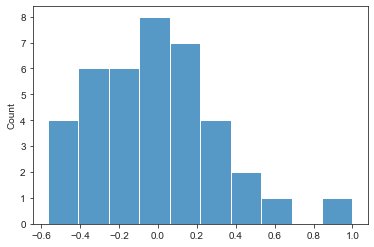

In [7]:
# Caluclate change in colonies over time per state
## Find states that have values in 2000
states_in_window = set(kag[
  kag.year == 2000
].state).intersection(
  set(kag[
    kag.year == 2015
  ].state)
)

## Calculate 15-year changes for the states we have data for
state_change = list()
for s in states_in_window:

  lvl_2015 = kag[
    (kag.state == s) & \
    (kag.year == 2015)
  ].loc[:,'numcol'].values[0]

  lvl_2000 = kag[
    (kag.state == s) & \
    (kag.year == 2000)
  ].loc[:,'numcol'].values[0]

  change = (lvl_2015 - lvl_2000) / lvl_2000
  state_change.append(change)

## Display histogram of state-by-state changes
change = np.array(state_change)
sns.histplot(x= change, bins=10)

plt.show()

The spread here looks basically Normal. Can we spot any correlation with Neonic?

<AxesSubplot:xlabel='neonicpercol', ylabel='yieldpercol'>

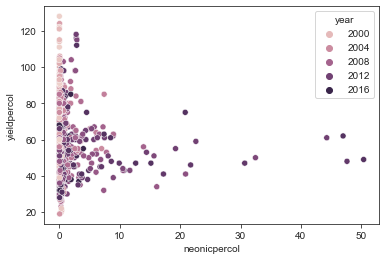

In [8]:
# Looking at per colony plot of yield per neonic
kag.loc[:,'neonicpercol'] = kag.nAllNeonic / kag.numcol

sns.scatterplot(
  x= kag.neonicpercol,
  y= kag.yieldpercol,
  hue= kag.year
)

Neonic use clearly increases in the sample's later years, with per-colony production centered around 50. What's the use of Neonics over time look like?

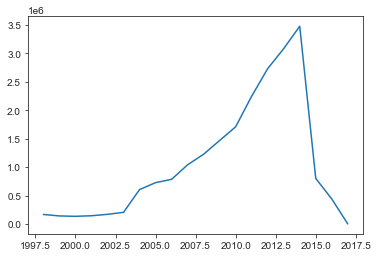

In [9]:
# Calculate yearly average of per-colony Neonics
neonic = kag[['year','nAllNeonic']].groupby(
  'year', as_index=False
).sum().sort_values('year').nAllNeonic.values

# Plot time series
fig, ax = plt.subplots()
ax.plot(years, neonic)

And what's the general distribution of colony production like?

<AxesSubplot:xlabel='yieldpercol', ylabel='Count'>

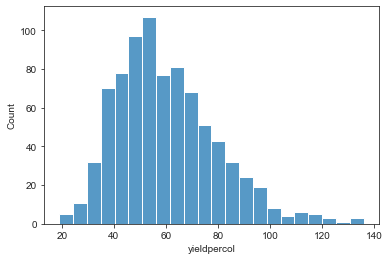

In [10]:
# Looking at distribution of production per colony
sns.histplot(x= kag.yieldpercol)

Looks basically Gaussian, centered around 50. Hmm! What are we really looking for here? Doesn't really look like Neonic pesticides are the issue?

<AxesSubplot:xlabel='yieldpercol', ylabel='Count'>

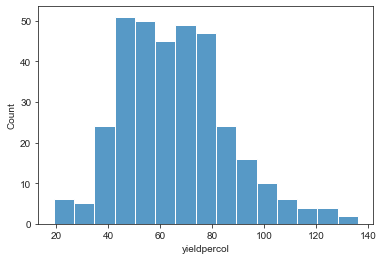

In [11]:
sns.histplot(
    x= kag[
      kag.year <= 2005
    ].yieldpercol
)

<AxesSubplot:xlabel='yieldpercol', ylabel='Count'>

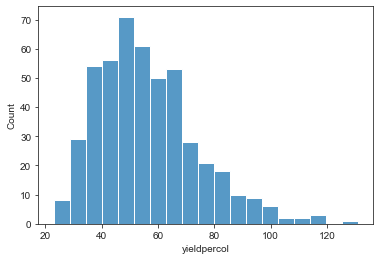

In [12]:
sns.histplot(
    x= kag[
      kag.year > 2005
    ].yieldpercol
)

# Finding distribution of input features

In [13]:
# Finding Normal dist params for yieldpercol
state_yieldpercol_params = kag[[
  'state','yieldpercol'
]].groupby('state').agg(['mean','std'])

In [14]:
state_yieldpercol_params

yieldpercol           
             mean        std
state                       
AL      63.100000  13.474733
AR      72.600000  12.089143
AZ      55.550000  10.947122
CA      50.800000  15.619152
CO      57.800000  14.248176
FL      75.700000  18.840326
GA      52.150000  10.737416
HI      99.600000  19.252888
IA      61.650000  13.592858
ID      41.800000   9.076285
IL      58.350000  13.168043
IN      59.300000  13.440316
KS      56.250000  12.489469
KY      50.000000  10.321159
LA      94.200000  12.788152
MD      45.000000   1.673320
ME      33.500000   9.406045
MI      65.150000  10.373423
MN      71.050000   9.955030
MO      53.700000   9.021028
MS      89.400000  17.233383
MT      78.700000  15.714894
NC      46.050000   6.652859
ND      85.100000  15.937047
NE      65.200000  12.622453
NJ      35.500000   8.792940
NM      53.866667   8.617811
NV      45.181818  12.188668
NY      65.750000  11.710881
OH      63.050000  10.630022
OK      46.333333   6.282250
OR      42.700000   7.182581
PA      49.800000   7.844542
SC      57.714286  20.838380
SD      73.700000  20.741771
TN      55.400000   7.802833
TX      69.850000   8.286165
UT      43.250000  11.059052
VA      39.500000   4.084631
VT      63.100000  13.837021
WA      46.950000   7.308791
WI      74.500000  13.212833
WV      45.600000   8.768364
WY      65.850000  14.198869

## Pulling in Matt's training matrices

In [15]:
df = pd.read_csv('../04 - Data/Final Data/DF_DROPPED_COLS.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Columns: 119 entries, year to Region_West
dtypes: float64(69), int64(50)
memory usage: 767.1 KB


In [17]:
df_train = df[
  df.year < 2016
]

In [18]:
state_names = [i[10:] for i in df_train.columns if i[:9] == 'StateName']

### Selecting columns for simulation

In [19]:
df_train.columns[:30]

Index(['year', 'numcol', 'yieldpercol', 'nCLOTHIANIDIN', 'nIMIDACLOPRID',
       'nTHIAMETHOXAM', 'nACETAMIPRID', 'nTHIACLOPRID', 'nAllNeonic',
       'prevyear_nCLOTHIANIDIN', 'prevyear_nIMIDACLOPRID',
       'prevyear_nTHIAMETHOXAM', 'prevyear_nACETAMIPRID',
       'prevyear_nTHIACLOPRID', 'NorthDakota_PrevYear', 'prevyearyield',
       'avg_temp', 'anomaly', 'varroa', 'spores', 'cbpv_max', 'dwv_max',
       'iapv_max', 'kbv_max', 'sbpv_max', 'abpv_max', 'dwv-b_max', 'lsv2_max',
       'mkv_max', 'cbpv_prob'],
      dtype='object')

In [20]:
df_train.columns[30:60]

Index(['dwv_prob', 'iapv_prob', 'kbv_prob', 'sbpv_prob', 'abpv_prob',
       'dwv-b_prob', 'lsv2_prob', 'mkv_prob', 'prevyearspores',
       'prevyearvarroa', 'urbanicity', 'Prev_Days_with_AQI', 'Prev_Good_Days',
       'Prev_Moderate_Days', 'Prev_Unhealthy_for_Sensitive_Groups_Days',
       'Prev_Unhealthy_Days', 'Prev_Very_Unhealthy_Days',
       'Prev_Hazardous_Days', 'Prev_Max_AQI', 'Prev_90th_Percentile_AQI',
       'Prev_Median_AQI', 'Prev_Days_CO', 'Prev_Days_NO2', 'Prev_Days_Ozone',
       'Prev_Days_PM2.5', 'Prev_Days_PM10', '5_Year_Avg_Days_with_AQI',
       '5_Year_Avg_Good_Days', '5_Year_Avg_Moderate_Days',
       '5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days'],
      dtype='object')

In [21]:
df_train.columns[60:90]

Index(['5_Year_Avg_Unhealthy_Days', '5_Year_Avg_Very_Unhealthy_Days',
       '5_Year_Avg_Hazardous_Days', '5_Year_Avg_Max_AQI',
       '5_Year_Avg_90th_Percentile_AQI', '5_Year_Avg_Median_AQI',
       '5_Year_Avg_Days_CO', '5_Year_Avg_Days_NO2', '5_Year_Avg_Days_Ozone',
       '5_Year_Avg_Days_PM2.5', '5_Year_Avg_Days_PM10', 'StateName_Alabama',
       'StateName_Arizona', 'StateName_Arkansas', 'StateName_California',
       'StateName_Colorado', 'StateName_Florida', 'StateName_Georgia',
       'StateName_Hawaii', 'StateName_Idaho', 'StateName_Illinois',
       'StateName_Indiana', 'StateName_Iowa', 'StateName_Kansas',
       'StateName_Kentucky', 'StateName_Louisiana', 'StateName_Maine',
       'StateName_Maryland', 'StateName_Michigan', 'StateName_Minnesota'],
      dtype='object')

In [22]:
df_train.columns[90:]

Index(['StateName_Mississippi', 'StateName_Missouri', 'StateName_Montana',
       'StateName_Nebraska', 'StateName_Nevada', 'StateName_New_Jersey',
       'StateName_New_Mexico', 'StateName_New_York',
       'StateName_North_Carolina', 'StateName_North_Dakota', 'StateName_Ohio',
       'StateName_Oklahoma', 'StateName_Oregon', 'StateName_Pennsylvania',
       'StateName_South_Carolina', 'StateName_South_Dakota',
       'StateName_Tennessee', 'StateName_Texas', 'StateName_Utah',
       'StateName_Vermont', 'StateName_Virginia', 'StateName_Washington',
       'StateName_West_Virginia', 'StateName_Wisconsin', 'StateName_Wyoming',
       'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West'],
      dtype='object')

In [23]:
X_train_preproc = df_train[[
  'prevyear_nCLOTHIANIDIN', 'prevyear_nIMIDACLOPRID',
  'prevyear_nTHIAMETHOXAM', 'prevyear_nACETAMIPRID',
  'prevyear_nTHIACLOPRID', 'NorthDakota_PrevYear', 'prevyearyield',
  'avg_temp', 'anomaly', 'varroa', 'spores', 'cbpv_max', 'dwv_max',
  'iapv_max', 'kbv_max', 'sbpv_max', 'abpv_max', 'dwv-b_max', 'lsv2_max',
  'mkv_max', 'cbpv_prob', 'dwv_prob', 'iapv_prob', 'kbv_prob', 'sbpv_prob',
  'abpv_prob', 'dwv-b_prob', 'lsv2_prob', 'mkv_prob', 'prevyearspores',
  'prevyearvarroa', 'urbanicity', 'Prev_Days_with_AQI', 'Prev_Good_Days',
  'Prev_Moderate_Days', 'Prev_Unhealthy_for_Sensitive_Groups_Days',
  'Prev_Unhealthy_Days', 'Prev_Very_Unhealthy_Days',
  'Prev_Hazardous_Days', 'Prev_Max_AQI', 'Prev_90th_Percentile_AQI',
  'Prev_Median_AQI', 'Prev_Days_CO', 'Prev_Days_NO2', 'Prev_Days_Ozone',
  'Prev_Days_PM2.5', 'Prev_Days_PM10', '5_Year_Avg_Days_with_AQI',
  '5_Year_Avg_Good_Days', '5_Year_Avg_Moderate_Days',
  '5_Year_Avg_Unhealthy_for_Sensitive_Groups_Days',
  '5_Year_Avg_Unhealthy_Days', '5_Year_Avg_Very_Unhealthy_Days',
  '5_Year_Avg_Hazardous_Days', '5_Year_Avg_Max_AQI',
  '5_Year_Avg_90th_Percentile_AQI', '5_Year_Avg_Median_AQI',
  '5_Year_Avg_Days_CO', '5_Year_Avg_Days_NO2', '5_Year_Avg_Days_Ozone',
  '5_Year_Avg_Days_PM2.5', '5_Year_Avg_Days_PM10', 'StateName_Alabama',
  'StateName_Arizona', 'StateName_Arkansas', 'StateName_California',
  'StateName_Colorado', 'StateName_Florida', 'StateName_Georgia',
  'StateName_Hawaii', 'StateName_Idaho', 'StateName_Illinois',
  'StateName_Indiana', 'StateName_Iowa', 'StateName_Kansas',
  'StateName_Kentucky', 'StateName_Louisiana', 'StateName_Maine',
  'StateName_Maryland', 'StateName_Michigan', 'StateName_Minnesota',
  'StateName_Mississippi', 'StateName_Missouri', 'StateName_Montana',
  'StateName_Nebraska', 'StateName_Nevada', 'StateName_New_Jersey',
  'StateName_New_Mexico', 'StateName_New_York',
  'StateName_North_Carolina', 'StateName_North_Dakota', 'StateName_Ohio',
  'StateName_Oklahoma', 'StateName_Oregon', 'StateName_Pennsylvania',
  'StateName_South_Carolina', 'StateName_South_Dakota',
  'StateName_Tennessee', 'StateName_Texas', 'StateName_Utah',
  'StateName_Vermont', 'StateName_Virginia', 'StateName_Washington',
  'StateName_West_Virginia', 'StateName_Wisconsin', 'StateName_Wyoming'
]]

In [24]:
X_train_preproc.columns[61]

'5_Year_Avg_Days_PM10'

In [25]:
X_train_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745 entries, 0 to 824
Columns: 106 entries, prevyear_nCLOTHIANIDIN to StateName_Wyoming
dtypes: float64(62), int64(44)
memory usage: 622.8 KB


In [26]:
X_train_preproc[
  X_train_preproc.StateName_Alabama == 1
].agg(['min','max']).loc['min','prevyear_nCLOTHIANIDIN']

0.0

In [27]:
dist_dict = dict()
for state in state_names:
  dist_dict[state] = X_train_preproc[
    X_train_preproc[f'StateName_{state}'] == 1
  ].agg(['min','max'])

In [28]:
X_train_preproc.prevyear_nCLOTHIANIDIN.min()

0.0

In [29]:
dist_dict_by_col = dict()
for col in X_train_preproc.columns[:62]:
  dist_dict_by_col[col] = dict()
  dist_dict_by_col[col]['min'] = X_train_preproc[col].min()
  dist_dict_by_col[col]['max'] = X_train_preproc[col].max()
  dist_dict_by_col[col]['range'] = \
    dist_dict_by_col[col]['max'] - dist_dict_by_col[col]['min']

In [30]:
df_dict = dict()
for col in X_train_preproc.columns[:62]:
  data = np.random.rand(1000)
  data = data * dist_dict_by_col[col]['range'] + dist_dict_by_col[col]['min']
  df_dict[col] = data

X_train_sim = pd.DataFrame(df_dict)
X_train_sim.head()

,prevyear_nCLOTHIANIDIN,prevyear_nIMIDACLOPRID,prevyear_nTHIAMETHOXAM,prevyear_nACETAMIPRID,prevyear_nTHIACLOPRID,NorthDakota_PrevYear,prevyearyield,avg_temp,anomaly,varroa,...,5_Year_Avg_Very_Unhealthy_Days,5_Year_Avg_Hazardous_Days,5_Year_Avg_Max_AQI,5_Year_Avg_90th_Percentile_AQI,5_Year_Avg_Median_AQI,5_Year_Avg_Days_CO,5_Year_Avg_Days_NO2,5_Year_Avg_Days_Ozone,5_Year_Avg_Days_PM2.5,5_Year_Avg_Days_PM10
0,4188.516348,122709.308129,31079.177944,30955.359331,2768.262327,108.188690,38.663581,69.674283,5.076645,8.248453,...,2.563331,0.021874,5928.579294,79.298423,23.959056,46.420607,102.311854,125.683565,102.208443,84.320947
1,26287.973579,134033.822827,54133.073165,7588.826984,1759.160256,71.059265,38.494472,59.538000,1.072005,3.056034,...,4.274575,1.018183,2111.927633,65.477957,33.261349,92.715554,61.932820,121.824961,31.442280,18.799727
2,161916.135545,41298.545929,21672.323956,11825.105150,80.935670,115.372233,42.912500,58.698467,4.106964,12.827813,...,3.383409,0.229147,7369.453826,95.148419,36.794548,60.570230,106.027104,106.799129,270.777666,102.351679
3,152671.874119,127000.319746,3752.067158,2403.273117,2438.423942,101.172232,120.628509,40.421294,-1.551841,9.494288,...,2.821263,0.801319,8021.801021,102.908807,42.970919,21.487328,42.013506,205.923968,230.111906,153.273639
4,122302.133701,10188.468718,8151.510151,3514.857828,2687.798379,106.530162,123.362941,44.832870,-2.525080,12.946495,...,0.983183,0.304187,11933.057958,60.417058,36.758892,94.048988,115.981504,313.610194,91.122309,131.018444
